In [170]:
import matplotlib.patches as patches  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from matplotlib.lines import Line2D  # type: ignore
import numpy as np  # type: ignore
import random

In [171]:
BOUNDS_ESPESSURE = (0.2, 1.5)  # mm
BOUNDS_DIAMETER = (10, 50)  # mm
BOUNDS_POSITION = (0, 1000)  # m

NUM_SENSORS = 6
NUM_PARAMETERS = 3
NUM_VARIABLES = NUM_SENSORS * NUM_PARAMETERS

ESPESSURE_INDEX = 0
DIAMETER_INDEX = 1
POSITION_INDEX = 2

In [172]:
NUM_ITERATIONS = 100
NUM_WOLFS = 1_000

In [173]:
def get_elements_in_chunks(lst, chunk_size=NUM_PARAMETERS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [174]:
def calculate_sensitivity(D, e, x, v=0.45, E=2e9):
    sens = 3 / 8 * (1 + v) * (D / 2) ** 2 / (E * e**2)
    s = 5.2e-6 * x + sens
    return s

In [175]:
def calculate_linearity(D, e, x):
    lin = (
        0.9509
        + 0.2274 * e
        - 0.0045 * D
        - 0.0863 * e**2
        + 0.0013 * e * D
        + 1.2732e-5 * D**2
    )
    l = -0.019 * x + lin
    return l

In [176]:
def circles_intersect(center1, diameter1, center2, diameter2):
    radius1 = diameter1 / 2
    radius2 = diameter2 / 2
    dist = abs(center1 - center2)

    return dist <= (radius1 + radius2)

In [177]:
def is_valid_position(new_sensor, sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    if not (
        (BOUNDS_ESPESSURE[0] < new_sensor[ESPESSURE_INDEX] < BOUNDS_ESPESSURE[1])
        and (BOUNDS_DIAMETER[0] < new_sensor[DIAMETER_INDEX] < BOUNDS_DIAMETER[1])
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] < BOUNDS_POSITION[1]) 
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] - new_sensor[DIAMETER_INDEX]) 
        and (BOUNDS_POSITION[1] > new_sensor[POSITION_INDEX] + new_sensor[DIAMETER_INDEX]) 
    ):
        return False
    
    for sensor in grouped_sensors:
        if not (
            sensor[ESPESSURE_INDEX] == new_sensor[ESPESSURE_INDEX]
            and sensor[DIAMETER_INDEX] == new_sensor[DIAMETER_INDEX]
            and sensor[POSITION_INDEX] == new_sensor[POSITION_INDEX]
        ) and circles_intersect(
            sensor[POSITION_INDEX],
            sensor[DIAMETER_INDEX],
            new_sensor[POSITION_INDEX],
            new_sensor[DIAMETER_INDEX],
        ):
            return False
    return True

In [178]:
def generate_sensor(sensors):
    while True:
        sensor = [
            np.random.uniform(*BOUNDS_ESPESSURE),
            np.random.uniform(*BOUNDS_DIAMETER),
            np.random.uniform(*BOUNDS_POSITION),
        ]

        if is_valid_position(sensor, sensors):
            break

    return sensor

In [179]:
def generate_sensors():
    sensors = []

    for _ in range(NUM_SENSORS):

        sensor = generate_sensor(sensors)
        sensors.extend(sensor)

    return sensors

In [180]:
def cost_function(position):
    sensors = get_elements_in_chunks(position)
    total_sensitivity = 0
    total_linearity = 0

    for sensor in sensors:
        D = sensor[DIAMETER_INDEX]
        e = sensor[ESPESSURE_INDEX]
        x = sensor[POSITION_INDEX] / 1000

        total_sensitivity += calculate_sensitivity(D, e, x)
        total_linearity += calculate_linearity(D, e, x)

    return (total_sensitivity, total_linearity)

In [181]:
def generate_wolf():
    position = generate_sensors()

    
    return {"position": position, "score": cost_function(position)}

In [182]:
def calculate_a(iteration):
    return 2 * (1 - iteration / (NUM_ITERATIONS - 1))

In [183]:
def calculate_distance(x_leader, x_omega, iteration):
    a = calculate_a(iteration)
    r1 = random.random()
    r2 = random.random()
    A = 2 * a * r1 - a
    C = 2 * r2
    D_leader = np.abs(C * np.array(x_leader) - x_omega)

    return D_leader, A

In [184]:
def get_non_dominated_wolfs(positions):
    is_position_dominated = [False] * len(positions)

    for i in range(len(positions)):
        for j in range(len(positions)):
            if i != j:
                y1_i, y2_i = cost_function(positions[i])
                y1_j, y2_j = cost_function(positions[j])

                if (
                    (y1_j >= y1_i)
                    and (y2_j >= y2_i)
                    and ((y1_j > y1_i) or (y2_j > y2_i))
                ):
                    is_position_dominated[i] = True
                    break

    return [
        positions[i] for i in range(len(positions)) if is_position_dominated[i] is False
    ]

In [185]:
def fix_position(sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    fixed_position = []
    for sensor in grouped_sensors:
        if not is_valid_position(sensor, fixed_position):
            sensor = generate_sensor(fixed_position)

        fixed_position.extend(sensor)

    return fixed_position

In [186]:
def update_position(wolfs, leaders, iteration):
    if leaders is None:
        leaders = [wolf["position"] for wolf in wolfs]
        leaders = get_non_dominated_wolfs(leaders)

    X_alpha = random.choice(leaders)
    X_beta = random.choice(leaders)
    X_delta = random.choice(leaders)

    for omega_wolf in wolfs:
        D_alpha, A_1 = calculate_distance(X_alpha, omega_wolf["position"], iteration)
        D_beta, A_2 = calculate_distance(X_beta, omega_wolf["position"], iteration)
        D_delta, A_3 = calculate_distance(X_delta, omega_wolf["position"], iteration)

        X_1 = X_alpha - A_1 * D_alpha
        X_2 = X_beta - A_2 * D_beta
        X_3 = X_delta - A_3 * D_delta

        omega_wolf["position"] = (X_1 + X_2 + X_3) / 3
        omega_wolf["position"] = fix_position(omega_wolf["position"])
        omega_wolf["score"] = cost_function(omega_wolf["position"])
        leaders.append(omega_wolf["position"])

    return get_non_dominated_wolfs(leaders)

In [187]:
def plot(particles):
    # Getting the score values as a NumPy array
    sensitivities = [particle["score"][0] for particle in particles]
    linearities = [particle["score"][1] for particle in particles]

    # Creating the plot for sensitivities
    plt.figure(figsize=(22, 4))
    plt.plot(
        sensitivities, [0] * len(sensitivities), marker="o", linestyle="", label="Sensitivities"
    )  # Plotting sensitivity points, y-axis fixed at zero
    plt.xlabel("Particle Index")  # Naming the x-axis
    plt.ylabel("Sensitivity")  # Naming the y-axis
    plt.title("Sensitivity Plot of Particles")
    plt.legend()  # Showing the legend
    plt.grid(True)  # Adding grid to the plot (optional)
    plt.show()  # Displaying the plot

    # Creating the plot for linearities
    plt.figure(figsize=(22, 4))
    plt.plot(
        linearities, [0] * len(linearities), marker="o", linestyle="", label="Linearities"
    )  # Plotting linearity points, y-axis fixed at zero
    plt.xlabel("Particle Index")  # Naming the x-axis
    plt.ylabel("Linearity")  # Naming the y-axis
    plt.title("Linearity Plot of Particles")
    plt.legend()  # Showing the legend
    plt.grid(True)  # Adding grid to the plot (optional)
    plt.show()  # Displaying the plot

In [188]:
wolfs = [generate_wolf() for _ in range(NUM_WOLFS)]

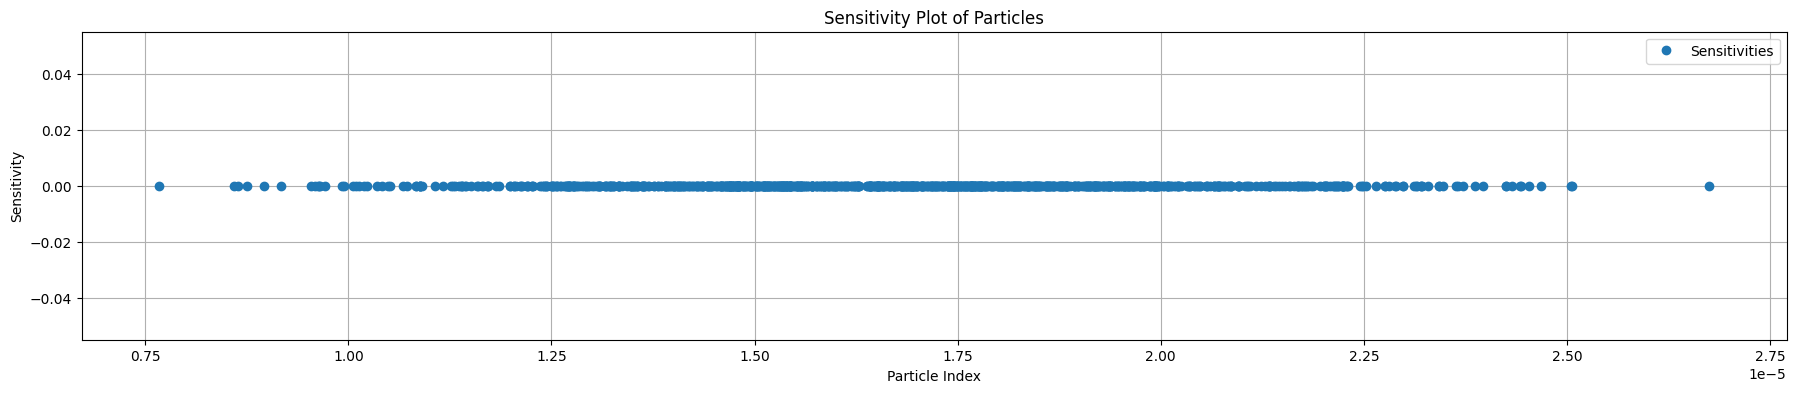

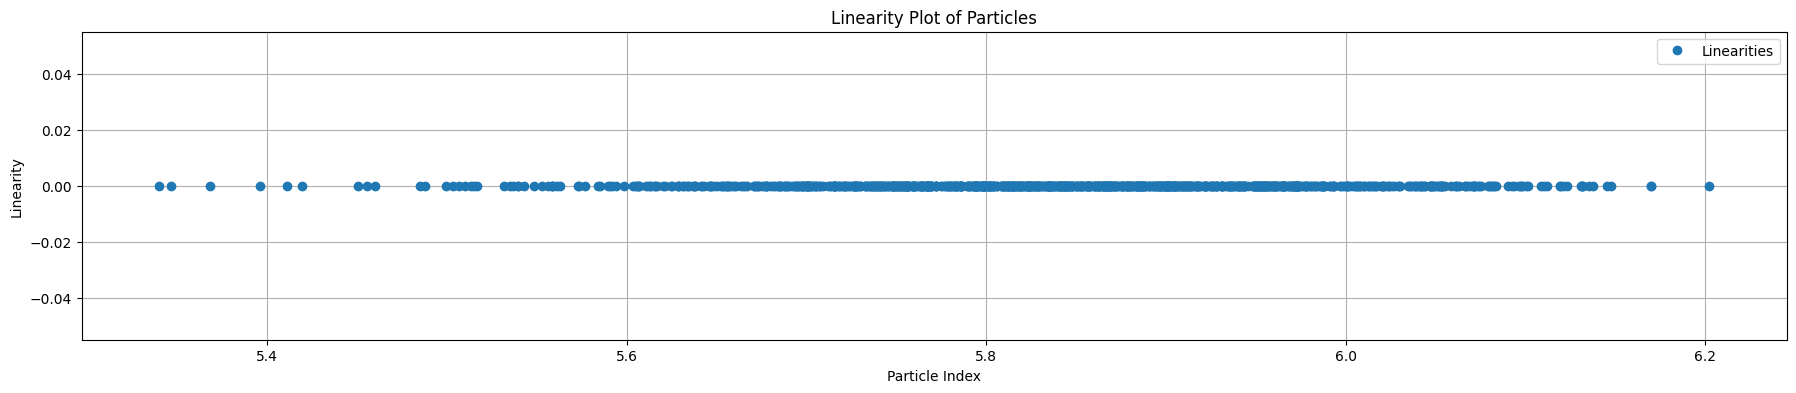

In [189]:
plot(wolfs)

In [190]:
i = 0
leaders = None

while True:
    print(f"Iteration {i+1}")

    leaders = update_position(wolfs, leaders, i)

    i += 1

    if i == NUM_ITERATIONS:
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

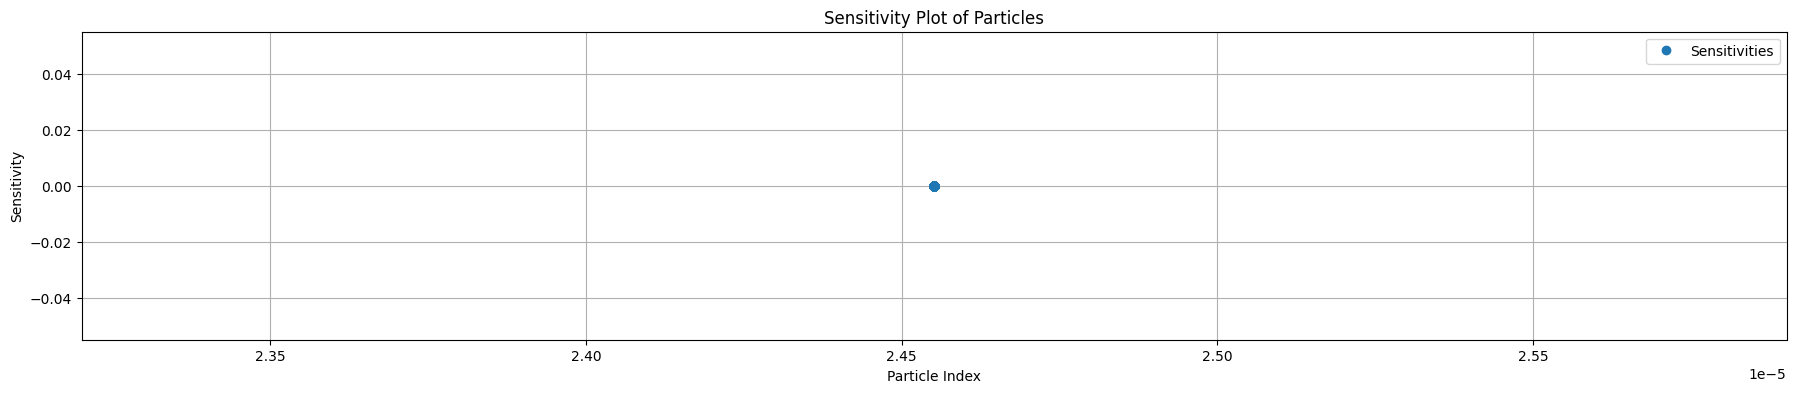

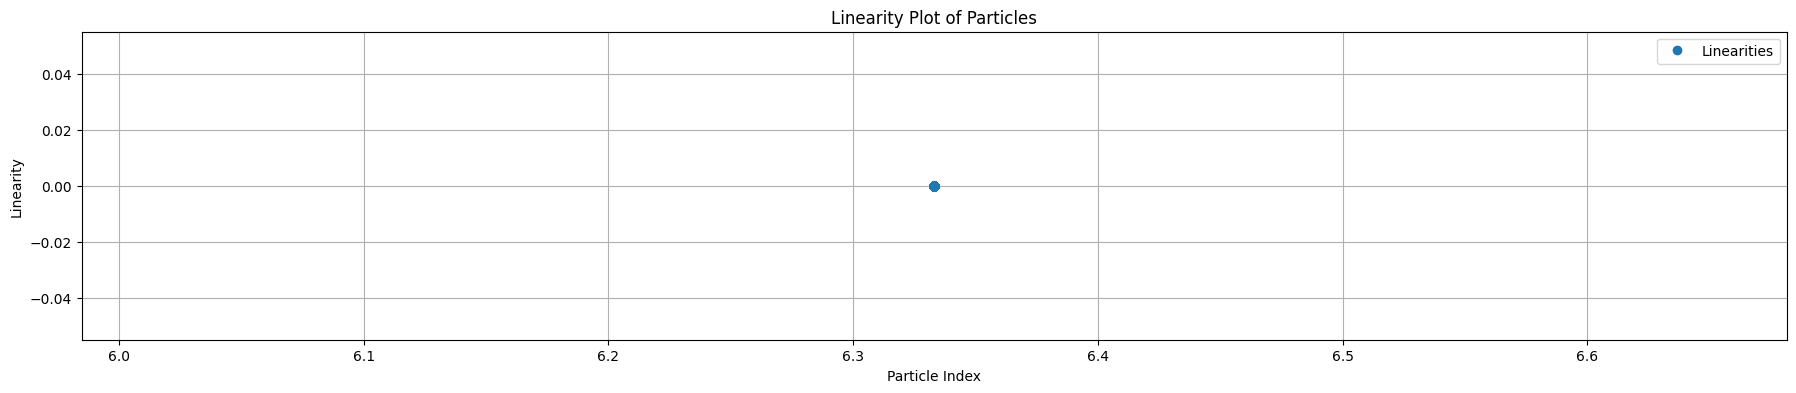

In [191]:
plot(wolfs)

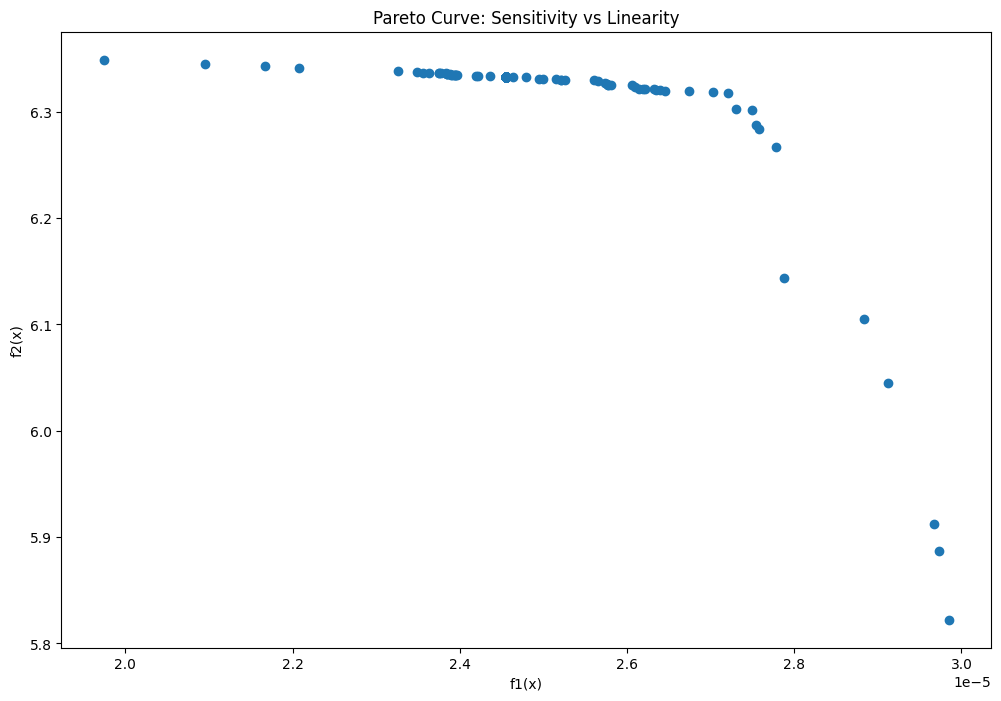

In [192]:
y1 = [cost_function(best)[0] for best in leaders]
y2 = [cost_function(best)[1] for best in leaders]

# Plotting the Pareto chart
plt.figure(figsize=(12, 8))
# Pontos não dominados
plt.scatter(y1, y2, marker="o", label="Non-dominated particles")
plt.xlabel("f1(x)")
plt.ylabel("f2(x)")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.show()

In [193]:
def perpendicular_distance(point, line_start, line_end):
    line_vector = np.array(line_end) - np.array(line_start)
    point_vector = np.array(point) - np.array(line_start)
    line_length = np.linalg.norm(line_vector)
    if line_length == 0:
        return np.linalg.norm(point_vector)
    else:
        line_vector /= line_length
        projection = np.dot(point_vector, line_vector)
        perpendicular_vector = point_vector - projection * line_vector
        return np.linalg.norm(perpendicular_vector)

In [194]:
def find_knee_point(sorted_particles):
    knee_point = None
    max_distance = -np.inf
    for i in range(1, len(sorted_particles) - 1):
        dist = perpendicular_distance(
            cost_function(sorted_particles[i]),
            cost_function(sorted_particles[0]),
            cost_function(sorted_particles[-1]),
        )
        if dist > max_distance:
            max_distance = dist
            knee_point = sorted_particles[i]
    return knee_point

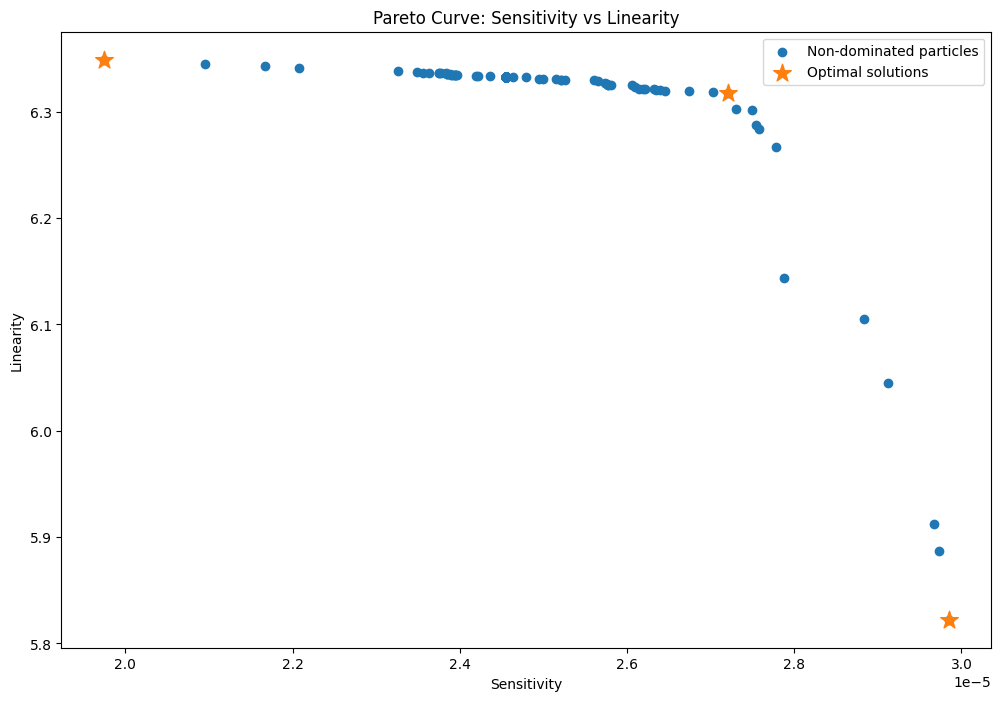

In [197]:
sorted_particles = sorted(leaders, key=lambda best: cost_function(best)[0])

knee_point = find_knee_point(sorted_particles)

solutions = [sorted_particles[0], knee_point, sorted_particles[-1]]

paretto_sensitivity = [cost_function(particle)[0] for particle in solutions]
paretto_linearity = [cost_function(particle)[1] for particle in solutions]

# Plotando o gráfico de Pareto
plt.figure(figsize=(12, 8))

# Pontos não dominados
plt.scatter(y1, y2, marker="o",  label="Non-dominated particles")

# Pontos ótimos
plt.scatter(paretto_sensitivity, paretto_linearity, s=175, marker="*",  label="Optimal solutions")

plt.xlabel("Sensitivity")
plt.ylabel("Linearity")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.legend()
plt.show()

In [198]:
for solution in solutions:
    sensors = get_elements_in_chunks(solution)
    print("Solution:")
    for i, sensor in enumerate(sensors):
        print(f"\tSensor {i+1}")
        print("\t\tEspessure (mm):", sensor[0])
        print("\t\tDiameter (mm):", sensor[1])
        print("\t\tPosition (mm):", sensor[2])

Solution:
	Sensor 1
		Espessure (mm): 1.251296094419353
		Diameter (mm): 14.88554679849301
		Position (mm): 639.567035894077
	Sensor 2
		Espessure (mm): 1.3247985827518318
		Diameter (mm): 10.728830495853856
		Position (mm): 809.4683840515069
	Sensor 3
		Espessure (mm): 1.3459251710816347
		Diameter (mm): 11.658947252179743
		Position (mm): 667.0261310884061
	Sensor 4
		Espessure (mm): 1.4044476538119104
		Diameter (mm): 10.903524304540095
		Position (mm): 116.396049876617
	Sensor 5
		Espessure (mm): 1.260382551578832
		Diameter (mm): 10.125227928787906
		Position (mm): 791.9404978302973
	Sensor 6
		Espessure (mm): 1.4293021748590766
		Diameter (mm): 10.737474959148315
		Position (mm): 765.8317503955708
Solution:
	Sensor 1
		Espessure (mm): 1.2935706693030877
		Diameter (mm): 14.830108841533148
		Position (mm): 709.0519971218514
	Sensor 2
		Espessure (mm): 1.411458808784683
		Diameter (mm): 11.22147397350249
		Position (mm): 922.392489969794
	Sensor 3
		Espessure (mm): 1.48491175624591

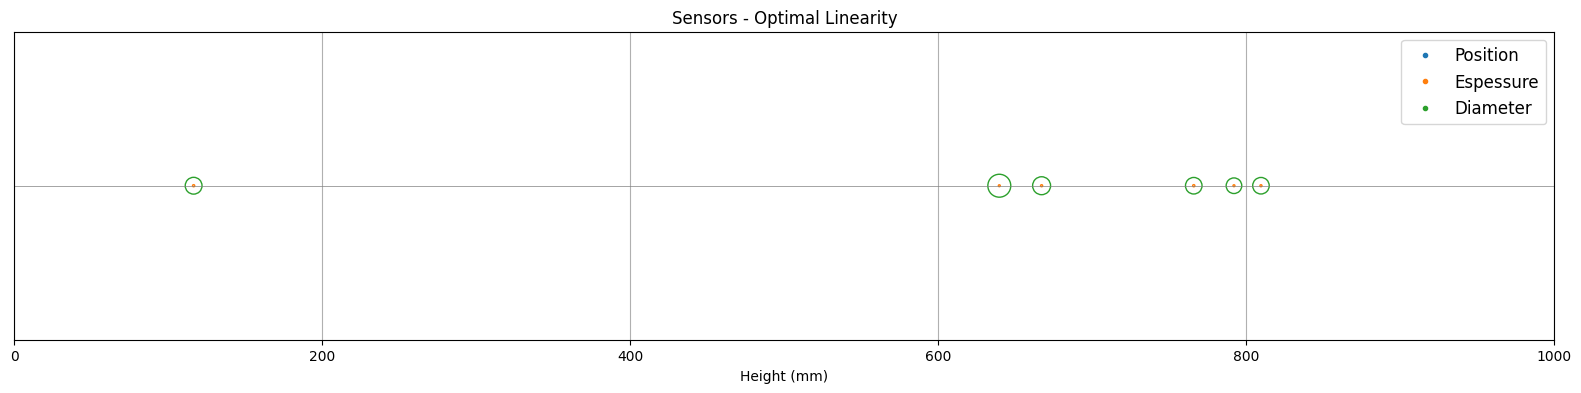

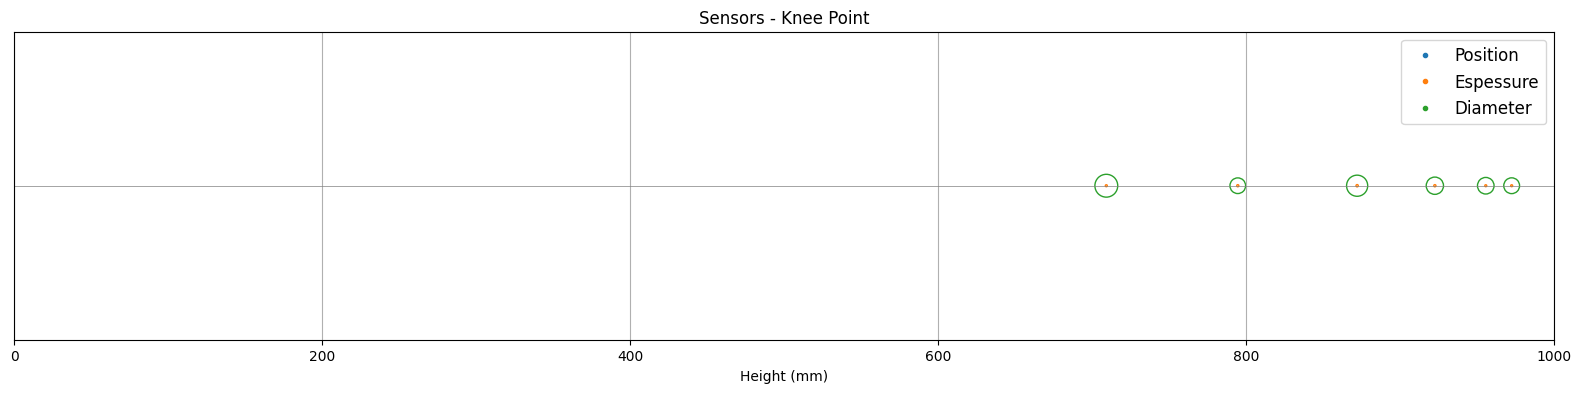

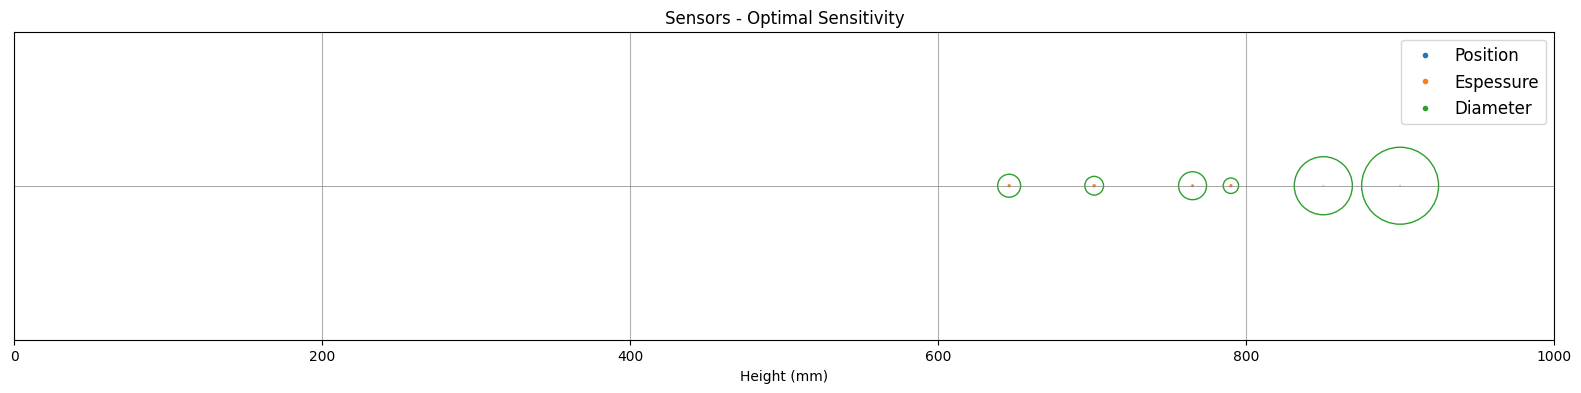

In [199]:
for i, solution in enumerate(solutions):
    # Obtém sensores a partir das posições
    sensors = get_elements_in_chunks(solution)

    # Cria uma figura e um eixo
    plt.figure(figsize=(22, 4))
    ax = plt.gca()
    ax.axhline(y=0, color="gray", linewidth=0.5)

    # Supondo que 'positions' seja uma lista de posições iniciais
    positions = [sensor[POSITION_INDEX] for sensor in sensors]

    # Plotar os pontos iniciais
    ax.plot(
        positions,
        np.zeros(len(positions)),
        ".",
        markersize=0,
        color="#1f77b4",  # Azul
        label="Position",
        linestyle="None",
    )

    # Iterar sobre os pontos e desenhar círculos em volta de cada um
    for sensor in sensors:
        # Desenhar os círculos
        internal_circle = patches.Circle(
            (sensor[POSITION_INDEX], 0),
            sensor[ESPESSURE_INDEX] / 2.0,
            edgecolor="#ff7f0e",  # Laranja
            facecolor="none",
            label="Espessure",
        )
        external_circle = patches.Circle(
            (sensor[POSITION_INDEX], 0),
            sensor[DIAMETER_INDEX] / 2.0,
            edgecolor="#2ca02c",  # Verde
            facecolor="none",
            label="Diameter",
        )

        # Adicionar os círculos ao eixo
        ax.add_patch(internal_circle)
        ax.add_patch(external_circle)

    # Ajustar o aspecto do gráfico para ser igual
    ax.set_aspect("equal", adjustable="box")
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Ajustar o limite do eixo x
    plt.xlim(*BOUNDS_POSITION)
    plt.ylim(-100, 100)

    # Configurar etiquetas e título
    plt.xlabel("Height (mm)")

    if i == 0:
        plt.title("Sensors - Optimal Linearity")
    elif i == 1:
        plt.title("Sensors - Knee Point")
    else:
        plt.title("Sensors - Optimal Sensitivity")

    plt.grid(True, axis="x")

    # Configurar a legenda corretamente
    custom_lines = [
        Line2D(
            [0], [0], color="#1f77b4", marker=".", linestyle="None", label="Position"
        ),
        Line2D(
            [0], [0], color="#ff7f0e", marker=".", linestyle="None", label="Espessure"
        ),
        Line2D(
            [0], [0], color="#2ca02c", marker=".", linestyle="None", label="Diameter"
        ),
    ]
    ax.legend(handles=custom_lines, fontsize=12)

    # Mostrar o gráfico
    plt.show()